# Обучение моделей

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay, make_scorer, PrecisionRecallDisplay
from sklearn.utils.class_weight import compute_class_weight

In [2]:
RANDOM_STATE = 99

In [3]:
df = pd.read_csv("../data/dataset_clean.csv")

Общее разделение на train/test для валидации финальной модели.

In [4]:
X = df.drop(columns=["label1", "label2"])
y = df[["label1", "label2"]]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=y
)

## 1. Бинарный классификатор Attack vs Benign

Разделение на train/test для первой модели.

In [6]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_train, y_train["label1"],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train["label1"]
)

Создание scorer для максимизации reacall по классу attack.

In [11]:
recall_attack = make_scorer(
    recall_score,
    pos_label="attack",
    average="binary"
)

Логистическая регрессия

In [12]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=500))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"]
}

grid_lr = GridSearchCV(
    log_reg_pipeline,
    param_grid_lr,
    cv=5,
    scoring=recall_attack,
    n_jobs=-1,
    verbose=2
)

grid_lr.fit(X1_train, y1_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500,
                                                           random_state=99))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l2']},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=attack, average=binary),
             verbose=2)

In [13]:
print("\n===== Logistic Regression =====")
print("Best params:", grid_lr.best_params_)

y1_pred_lr = grid_lr.predict(X1_test)
print(classification_report(y1_test, y1_pred_lr))


===== Logistic Regression =====
Best params: {'model__C': 1, 'model__penalty': 'l2'}
              precision    recall  f1-score   support

      attack       0.95      0.78      0.86     16271
      benign       0.87      0.98      0.92     24624

    accuracy                           0.90     40895
   macro avg       0.91      0.88      0.89     40895
weighted avg       0.90      0.90      0.90     40895



In [24]:
grid_lr.best_score_

0.780377996312231

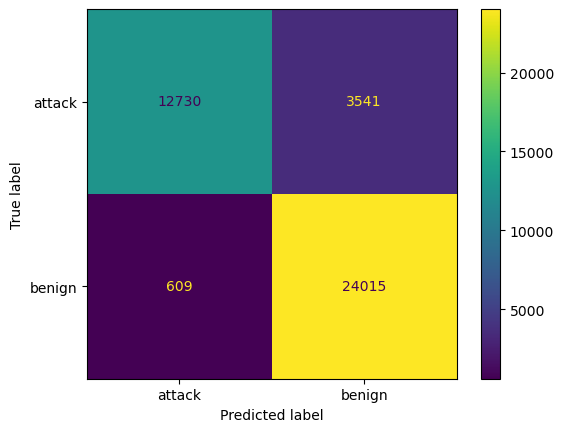

In [14]:
ConfusionMatrixDisplay.from_predictions(y1_test, y1_pred_lr)

Случайный лес

In [18]:
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring=recall_attack,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X1_train, y1_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=99),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=attack, average=binary),
             verbose=2)

In [19]:
print("\n===== Random Forest =====")
print("Best params:", grid_rf.best_params_)

y1_pred_rf = grid_rf.predict(X1_test)
print(classification_report(y1_test, y1_pred_rf))


===== Random Forest =====
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

      attack       0.98      0.87      0.92     16271
      benign       0.92      0.99      0.95     24624

    accuracy                           0.94     40895
   macro avg       0.95      0.93      0.94     40895
weighted avg       0.94      0.94      0.94     40895



In [25]:
grid_rf.best_score_

0.865980331899201

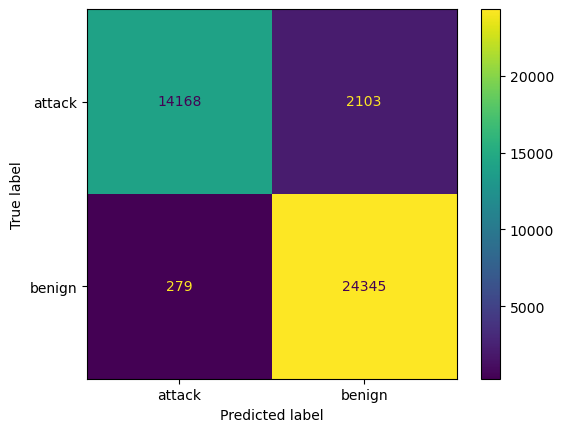

In [20]:
ConfusionMatrixDisplay.from_predictions(y1_test, y1_pred_rf)

Градиентный бустинг

In [ ]:
cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    eval_metric="TotalF1",
    auto_class_weights='Balanced',
    task_type="GPU",
    devices="0",  
    verbose=2
)

param_grid_cat = {
    "depth": [4, 6, 8],
    "learning_rate": [0.1, 1],
    "iterations": [500, 1000]
}

grid_cat = GridSearchCV(
    cat,
    param_grid_cat,
    cv=5,
    scoring=recall_attack,
    n_jobs=1,
    verbose=1
)

grid_cat.fit(X1_train, y1_train)

In [27]:
print("\n===== CatBoost =====")
print("Best params:", grid_cat.best_params_)

y1_pred_cat = grid_cat.predict(X1_test)
print(classification_report(y1_test, y1_pred_cat))


===== CatBoost =====
Best params: {'depth': 4, 'iterations': 1000, 'learning_rate': 1}
              precision    recall  f1-score   support

      attack       0.99      0.87      0.92     16271
      benign       0.92      0.99      0.95     24624

    accuracy                           0.94     40895
   macro avg       0.95      0.93      0.94     40895
weighted avg       0.95      0.94      0.94     40895



In [30]:
grid_cat.best_score_

0.8656883835279656

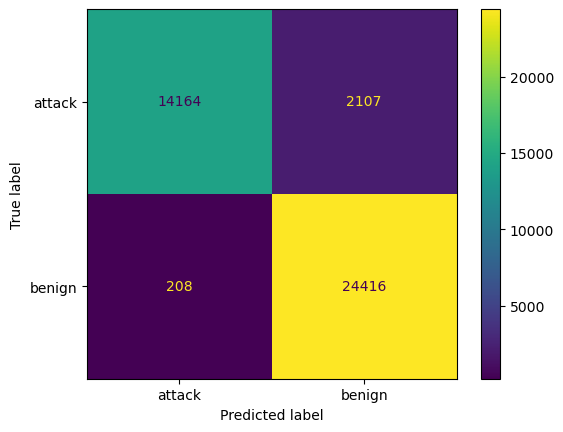

In [28]:
ConfusionMatrixDisplay.from_predictions(y1_test, y1_pred_cat)

Подбор порога разделения классов

In [98]:
y1_probas_cat = grid_cat.predict_proba(X1_test)[:, 0]

c:\Users\Nikita\anaconda3\envs\env_for_course\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


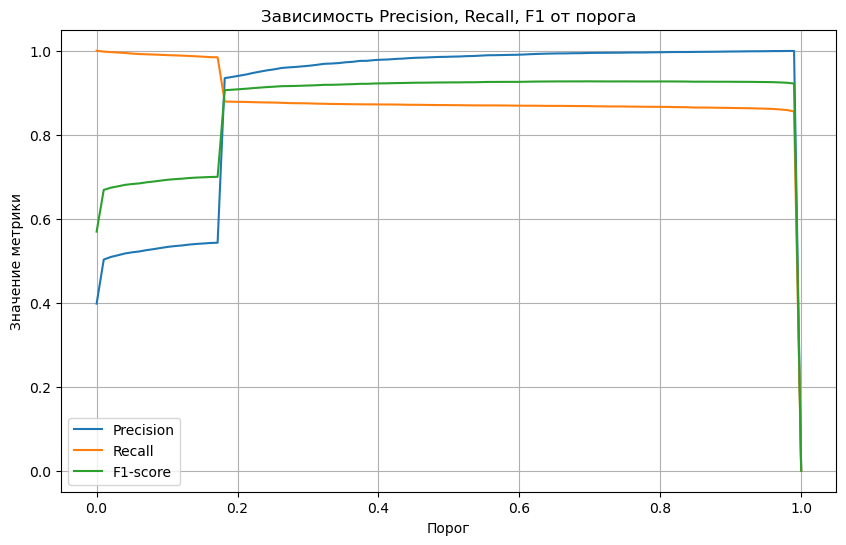

In [93]:
thresholds = np.linspace(0, 1, 100)

precisions = []
recalls = []
f1s = []

for thr in thresholds:
    preds = np.where(y1_probas_cat > thr, "attack", "benign")

    precisions.append(precision_score(y1_test, preds, pos_label="attack"))
    recalls.append(recall_score(y1_test, preds, pos_label="attack"))
    f1s.append(f1_score(y1_test, preds, pos_label="attack"))

plt.figure(figsize=(10, 6))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")

plt.xlabel("Порог")
plt.ylabel("Значение метрики")
plt.title("Зависимость Precision, Recall, F1 от порога")
plt.legend()
plt.grid(True)
plt.show()

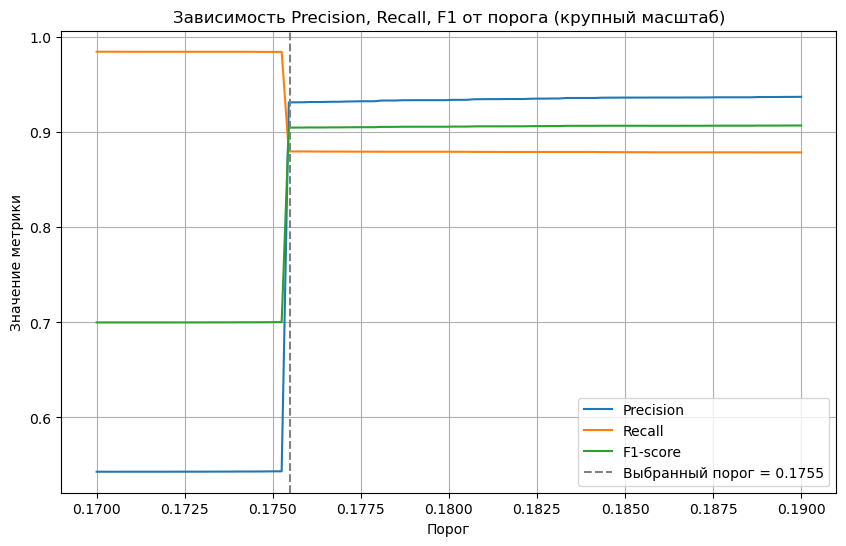

In [117]:
thresholds = np.linspace(0.17, 0.19, 100)

precisions = []
recalls = []
f1s = []

for thr in thresholds:
    preds = np.where(y1_probas_cat > thr, "attack", "benign")

    precisions.append(precision_score(y1_test, preds, pos_label="attack"))
    recalls.append(recall_score(y1_test, preds, pos_label="attack"))
    f1s.append(f1_score(y1_test, preds, pos_label="attack"))

plt.figure(figsize=(10, 6))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")

plt.axvline(0.1755, color="gray", linestyle="--", label="Выбранный порог = 0.1755")

plt.xlabel("Порог")
plt.ylabel("Значение метрики")
plt.title("Зависимость Precision, Recall, F1 от порога (крупный масштаб)")
plt.legend()
plt.grid(True)
plt.show()

In [114]:
y1_new_pred_cat = np.where(y1_probas_cat > 0.1755, "attack", "benign")

In [115]:
print(classification_report(y1_test, y1_new_pred_cat))

              precision    recall  f1-score   support

      attack       0.93      0.88      0.90     16271
      benign       0.92      0.96      0.94     24624

    accuracy                           0.93     40895
   macro avg       0.93      0.92      0.92     40895
weighted avg       0.93      0.93      0.93     40895



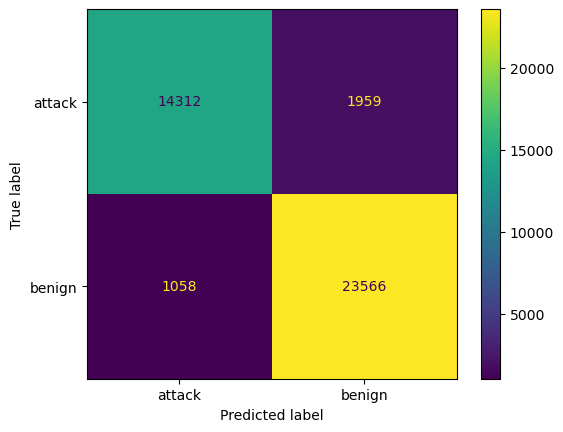

In [116]:
ConfusionMatrixDisplay.from_predictions(y1_test, y1_new_pred_cat)

Лучший полученный reacall для класса attack = 0,88 при пороге 0,1755. При более низких значениях порога можно получить более высокие значения recall, но при этом резко повышается число False Positive результатов, а следовательно резко падает precision.

In [126]:
import pickle

with open("../models/grid_cat.pkl", "wb") as f:
    pickle.dump(grid_cat, f)

## 2. Классификатор типов атак

Разделение на train/test для второй модели

In [132]:
# Индексы записей с атаками
attack_idx = y_train[y_train["label1"] == "attack"].index

In [136]:
X2 = X_train.loc[attack_idx]
y2 = y_train.loc[attack_idx, "label2"]

In [137]:
y2.value_counts()

label2
recon         30283
dos           16578
ddos          16250
mitm           7256
malware        6787
web            2516
bruteforce     1681
Name: count, dtype: int64

In [138]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y2
)

Логистическая регрессия

In [153]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        # class_weight='balanced', 
        random_state=RANDOM_STATE, 
        max_iter=500))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"]
}

grid_lr = GridSearchCV(
    log_reg_pipeline,
    param_grid_lr,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_lr.fit(X2_train, y2_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Nikita\anaconda3\envs\env_for_course\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=500,
                                                           random_state=99))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l2']},
             return_train_score=True, scoring='f1_macro', verbose=2)

In [154]:
print("\n===== Logistic Regression =====")
print("Best params:", grid_lr.best_params_)

y2_pred_lr = grid_lr.predict(X2_test)
print(classification_report(y2_test, y2_pred_lr))


===== Logistic Regression =====
Best params: {'model__C': 10, 'model__penalty': 'l2'}
              precision    recall  f1-score   support

  bruteforce       0.69      0.38      0.49       336
        ddos       0.93      0.80      0.86      3250
         dos       0.91      0.84      0.87      3316
     malware       0.85      0.77      0.81      1358
        mitm       0.72      0.73      0.73      1451
       recon       0.82      0.96      0.89      6057
         web       0.94      0.84      0.89       503

    accuracy                           0.85     16271
   macro avg       0.84      0.76      0.79     16271
weighted avg       0.86      0.85      0.85     16271



In [155]:
grid_lr.best_score_

0.7877049949782544

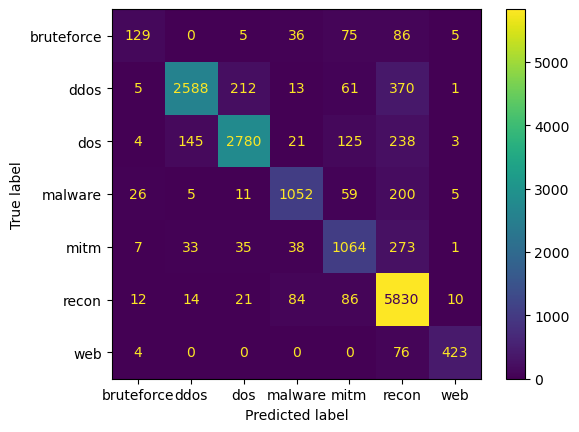

In [156]:
ConfusionMatrixDisplay.from_predictions(y2_test, y2_pred_lr)

Случайный лес

In [157]:
rf = RandomForestClassifier(
    # class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X2_train, y2_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=99),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400]},
             scoring='f1_macro', verbose=2)

In [158]:
print("\n===== Random Forest =====")
print("Best params:", grid_rf.best_params_)

y2_pred_rf = grid_rf.predict(X2_test)
print(classification_report(y2_test, y2_pred_rf))


===== Random Forest =====
Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 400}
              precision    recall  f1-score   support

  bruteforce       0.97      0.76      0.86       336
        ddos       0.98      0.88      0.93      3250
         dos       0.98      0.93      0.95      3316
     malware       0.97      0.91      0.94      1358
        mitm       0.96      0.91      0.93      1451
       recon       0.88      0.99      0.93      6057
         web       0.99      0.85      0.92       503

    accuracy                           0.93     16271
   macro avg       0.96      0.89      0.92     16271
weighted avg       0.94      0.93      0.93     16271



In [165]:
grid_rf.best_score_

0.9160763077947498

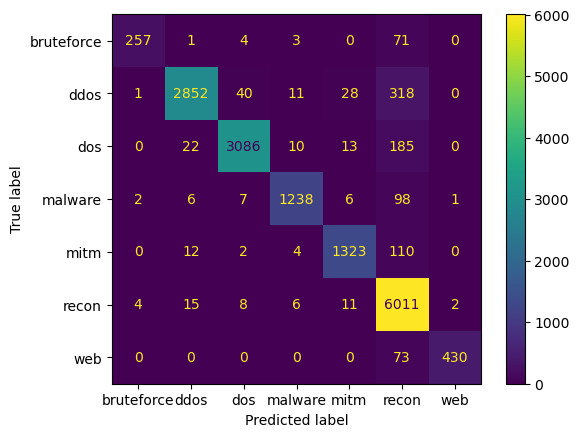

In [159]:
ConfusionMatrixDisplay.from_predictions(y2_test, y2_pred_rf)

Градиентный бустинг

In [160]:
cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    eval_metric="TotalF1",
    # auto_class_weights='Balanced',
    task_type="GPU",
    devices="0",  
    verbose=2
)

param_grid_cat = {
    "depth": [4, 6, 8],
    "learning_rate": [0.1, 1],
    "iterations": [500, 1000]
}

grid_cat = GridSearchCV(
    cat,
    param_grid_cat,
    cv=5,
    scoring="f1_macro",
    n_jobs=1,
    verbose=1
)

grid_cat.fit(X2_train, y2_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.7243105	total: 13.2ms	remaining: 6.58s
2:	learn: 0.7359382	total: 36.8ms	remaining: 6.09s
4:	learn: 0.7491597	total: 58.1ms	remaining: 5.75s
6:	learn: 0.7490908	total: 78.3ms	remaining: 5.52s
8:	learn: 0.7607962	total: 99.2ms	remaining: 5.41s
10:	learn: 0.7748318	total: 120ms	remaining: 5.32s
12:	learn: 0.7820108	total: 141ms	remaining: 5.28s
14:	learn: 0.7847764	total: 162ms	remaining: 5.23s
16:	learn: 0.7938812	total: 183ms	remaining: 5.19s
18:	learn: 0.8017377	total: 203ms	remaining: 5.15s
20:	learn: 0.8036422	total: 223ms	remaining: 5.08s
22:	learn: 0.8101041	total: 242ms	remaining: 5.02s
24:	learn: 0.8163456	total: 260ms	remaining: 4.94s
26:	learn: 0.8303914	total: 278ms	remaining: 4.87s
28:	learn: 0.8352753	total: 296ms	remaining: 4.81s
30:	learn: 0.8478226	total: 315ms	remaining: 4.77s
32:	learn: 0.8513368	total: 334ms	remaining: 4.73s
34:	learn: 0.8521489	total: 353ms	remaining: 4.69s
36:	learn: 0.8548907	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000184BF116600>,
             n_jobs=1,
             param_grid={'depth': [4, 6, 8], 'iterations': [500, 1000],
                         'learning_rate': [0.1, 1]},
             scoring='f1_macro', verbose=1)

In [161]:
print("\n===== CatBoost =====")
print("Best params:", grid_cat.best_params_)

y2_pred_cat = grid_cat.predict(X2_test)
print(classification_report(y2_test, y2_pred_cat))


===== CatBoost =====
Best params: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}
              precision    recall  f1-score   support

  bruteforce       0.98      0.76      0.85       336
        ddos       0.98      0.88      0.93      3250
         dos       0.98      0.93      0.95      3316
     malware       0.97      0.91      0.94      1358
        mitm       0.96      0.91      0.93      1451
       recon       0.87      0.99      0.93      6057
         web       0.99      0.85      0.92       503

    accuracy                           0.93     16271
   macro avg       0.96      0.89      0.92     16271
weighted avg       0.94      0.93      0.93     16271



In [162]:
grid_cat.best_score_

0.9146680822606863

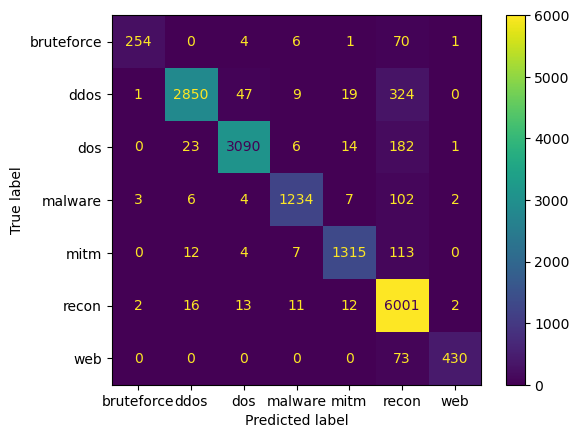

In [163]:
ConfusionMatrixDisplay.from_predictions(y2_test, y2_pred_cat)

Модели RandomForest и CatBoost дали почти одинаковые значения метрик. В качестве итоговой модели используем CatBoost, так как модели на основе градиентного бустинга обычно быстрее работают на инференсе из-за меньшей глубины деревьев.

In [164]:
with open("../models/grid_cat_2.pkl", "wb") as f:
    pickle.dump(grid_cat, f)

# 3. Объединение двух моделей

In [168]:
with open("../models/grid_cat_1.pkl", "rb") as f:
    binary_model = pickle.load(f)

In [169]:
with open("../models/grid_cat_2.pkl", "rb") as f:
    attack_model = pickle.load(f)

In [179]:
def predict(X, binary_model, attack_model):
    # Предсказание первой модели
    binary_preds = binary_model.predict(X)    # benign / attack

    # Массив для финальных предсказаний
    final_preds = []

    for i, pred in enumerate(binary_preds):
        if pred == "benign":
            final_preds.append("benign")
        else:
            # если attack — запускаем вторую модель
            attack_type = attack_model.predict(X.iloc[i:i+1])[0][0]
            final_preds.append(attack_type)

    return final_preds

In [180]:
final_preds = predict(X_test, binary_model, attack_model)

In [181]:
y_test_final = y_test["label2"]

In [182]:
y_test_final

89732     benign
36987     benign
113424    benign
117013    benign
153309      mitm
           ...  
19710     benign
76284     benign
208732     recon
196542     recon
194716     recon
Name: label2, Length: 22720, dtype: object

In [184]:
print(classification_report(y_test_final, final_preds))

              precision    recall  f1-score   support

      benign       0.92      0.99      0.95     13680
  bruteforce       0.92      0.76      0.84       187
        ddos       0.98      0.89      0.93      1806
         dos       0.98      0.93      0.96      1842
     malware       0.96      0.91      0.94       754
        mitm       0.95      0.89      0.92       806
       recon       0.96      0.78      0.86      3365
         web       1.00      0.82      0.90       280

    accuracy                           0.94     22720
   macro avg       0.96      0.87      0.91     22720
weighted avg       0.94      0.94      0.94     22720



В итоге получчилось достичь F1 по макро усреднению = 0,91, что является достаточно хорошим результатом.